# Importing Library

In [ ]:
! pip install config

In [ ]:
! pip install folium

In [1]:
import pandas as pd
import numpy as np
import requests
import folium
import config
from math import radians, cos, sin, asin, sqrt

# DATA VISUALISATION
import matplotlib.pyplot as plt
import seaborn as sns


# Data Sourcing

## Accidents Data Loading and necessary PrePreprocessing

In [2]:
data2020 = pd.read_csv('../raw_data/B_Accident_data/AfSBBB_BE_LOR_Strasse_Strassenverkehrsunfaelle_2020_Datensatz.csv', sep=';')
data2019 = pd.read_csv('../raw_data/B_Accident_data/AfSBBB_BE_LOR_Strasse_Strassenverkehrsunfaelle_2019_Datensatz.csv', sep=';')
data2018 = pd.read_csv('../raw_data/B_Accident_data/AfSBBB_BE_LOR_Strasse_Strassenverkehrsunfaelle_2018_Datensatz.csv', sep=';')


In [3]:
data2018.keys()
#data2018 contains an additional column 'STRASSE'

Index(['OBJECTID', 'LAND', 'BEZ', 'LOR', 'STRASSE', 'LOR_ab_2021', 'UJAHR',
       'UMONAT', 'USTUNDE', 'UWOCHENTAG', 'UKATEGORIE', 'UART', 'UTYP1',
       'ULICHTVERH', 'IstRad', 'IstPKW', 'IstFuss', 'IstKrad', 'IstGkfz',
       'IstSonstig', 'STRZUSTAND', 'LINREFX', 'LINREFY', 'XGCSWGS84',
       'YGCSWGS84'],
      dtype='object')

In [4]:
#renaming column 'IstSonstig' so its equal to data 2019 and 2020
data2018 = data2018.rename(columns={'IstSonstig': 'IstSonstige'});

In [5]:
#renaming column 'STRZUSTAND' so its equal to data 2019 and 2020
data2018 = data2018.rename(columns={'STRZUSTAND': 'USTRZUSTAND'});

In [6]:
df = pd.concat([data2018, data2019, data2020])

In [7]:
df = df.rename(columns={'OBJECTID': 'objectID', 'LAND': 'state', 'BEZ': 'district', 'LOR': 'LOR', 'STRASSE': 'street', 'LOR_ab_2021' : 'LOR_2021', 'UJAHR':'year', 'UMONAT': 'month', 'USTUNDE': 'hour', 'UWOCHENTAG':'weekday', 'UKATEGORIE':'category', 'UART' : 'accident_kind', 'UTYP1': 'accident_type','ULICHTVERH' : 'light_condition', 'IstRad': 'bicycle', 'IstPKW' : 'car', 'IstFuss' : 'pedestrian', 'IstKrad': 'motorcycle', 'IstGkfz': 'goods_vehicle','IstSonstige': 'others', 'USTRZUSTAND': 'road_condition', 'LINREFX' : 'LINREFX', 'LINREFY': 'LINREFY', 'XGCSWGS84': 'XGCSWGS84','YGCSWGS84': 'YGCSWGS84'})

In [8]:
df.keys()

Index(['objectID', 'state', 'district', 'LOR', 'street', 'LOR_2021', 'year',
       'month', 'hour', 'weekday', 'category', 'accident_kind',
       'accident_type', 'light_condition', 'bicycle', 'car', 'pedestrian',
       'motorcycle', 'goods_vehicle', 'others', 'road_condition', 'LINREFX',
       'LINREFY', 'XGCSWGS84', 'YGCSWGS84'],
      dtype='object')

In [9]:
#PrePreprocessing
df['XGCSWGS84'] = df['XGCSWGS84'].map(lambda x: x.replace(',','.')).astype(float)
df['YGCSWGS84'] = df['YGCSWGS84'].map(lambda x: x.replace(',','.')).astype(float)
df['LINREFX'] = df['LINREFX'].map(lambda x: x.replace(',','.')).astype(float)
df['LINREFY'] = df['LINREFY'].map(lambda x: x.replace(',','.')).astype(float)

In [14]:
df = df.set_index('objectID')

In [15]:
#droppping faulty row
df = df.drop(index=201196)

In [16]:
#changing string objects to integers
df['others'] = df['others'].astype(int)
df['road_condition'] = df['road_condition'].astype(int)

In [18]:
#1 == Accidents with bicycles involved
df.bicycle.value_counts()

0    23544
1    15306
Name: bicycle, dtype: int64

In [20]:
bike_accidents = pd.DataFrame(df.groupby('year').bicycle.value_counts())
bike_accidents

bicycle
year bicycle         
2018 0           8459
     1           5192
2019 0           8384
     1           5005
2020 0           6701
     1           5109

In [21]:
#IMPORTANT: Filtering out all accidents not related to bikes
df = df[df.bicycle == 1]

In [23]:
#dropping 100% unnecessary columns
df = df.drop(columns=['bicycle', 'state'])

In [ ]:
#Optional for look at individual years

#accidents = {
#    'w/ bicycle': [
#    data2018.IstRad.value_counts()[1],
#    data2019.IstRad.value_counts()[1],
#    data2020.IstRad.value_counts()[1]
#    ],
#    'w/o bicycle': [
#    data2018.IstRad.value_counts()[0], 
#    data2019.IstRad.value_counts()[0], 
#    data2020.IstRad.value_counts()[0]
#    ],
#    'involvement (%)': [
#    round(data2018.IstRad.value_counts()[1]/len(data2018)*100, 2),
#    round(data2019.IstRad.value_counts()[1]/len(data2019)*100, 2),
#    round(data2020.IstRad.value_counts()[1]/len(data2020)*100, 2)   
#    ],
#}
#
#df = pd.DataFrame(accidents, index = [2018, 2019, 2020])
#df

## EDA

In [24]:
df.head()

,district,LOR,street,LOR_2021,year,month,hour,weekday,category,accident_kind,...,car,pedestrian,motorcycle,goods_vehicle,others,road_condition,LINREFX,LINREFY,XGCSWGS84,YGCSWGS84
objectID,,,,,,,,,,,,,,,,,,,,,
112747,3,3020209.0,Niederschönhausen,3200206.0,2018,1,15,4,3,6,...,0,1,0,0,0,1,798261.3849,5835047.260,13.403228,52.583472
112892,3,3071639.0,Bötzowstraße,3701660.0,2018,1,11,5,3,5,...,1,0,0,0,0,1,800551.7210,5829808.492,13.432186,52.535255
112902,2,2050602.0,Samariterviertel,2500729.0,2018,1,8,2,3,5,...,1,0,0,0,0,0,803320.7292,5827627.446,13.470897,52.514173
112921,1,1011204.0,Leipziger Straße ...,1100207.0,2018,1,19,4,3,5,...,1,0,0,0,0,1,798174.6913,5826939.978,13.394673,52.510848
112947,9,9020601.0,Schnellerstraße ...,9200613.0,2018,1,18,4,2,5,...,1,0,0,0,0,1,806109.6297,5821644.404,13.506372,52.458993


In [25]:
df.keys()

Index(['district', 'LOR', 'street', 'LOR_2021', 'year', 'month', 'hour',
       'weekday', 'category', 'accident_kind', 'accident_type',
       'light_condition', 'car', 'pedestrian', 'motorcycle', 'goods_vehicle',
       'others', 'road_condition', 'LINREFX', 'LINREFY', 'XGCSWGS84',
       'YGCSWGS84'],
      dtype='object')

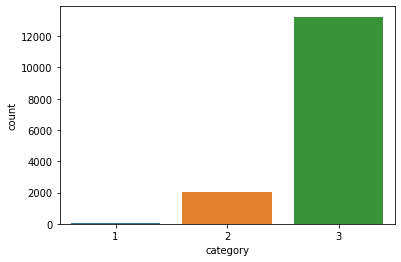

In [26]:
#countplot for accident category
sns.countplot(data= df, x ='category');

In [27]:
#number of fatal accidents
len(df[df.category == 1])

33

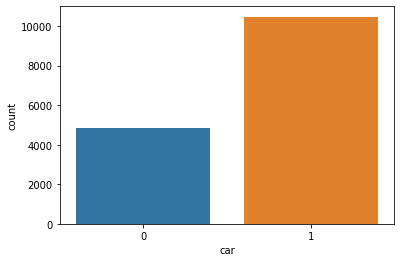

In [28]:
#countplot for accidents involving cars and not
sns.countplot(data= df, x ='car');

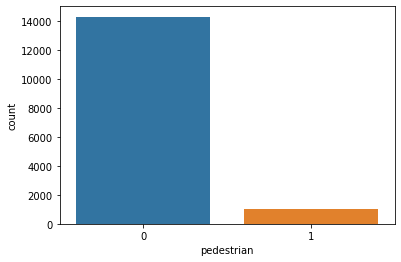

In [29]:
#countplot for accidents involving pedestrians
sns.countplot(data= df, x ='pedestrian');

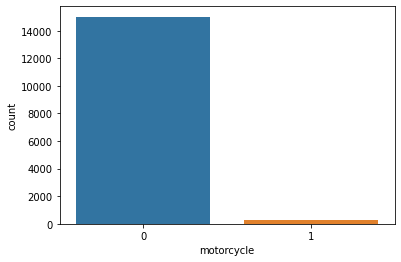

In [30]:
#countplot for accidents involving motorcycles
sns.countplot(data= df, x ='motorcycle');

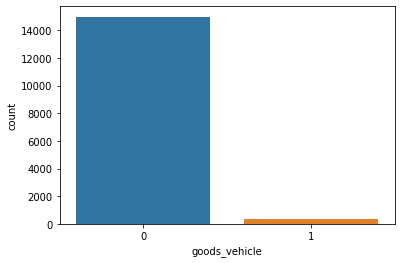

In [31]:
#countplot for accidents involving goods vehicles
sns.countplot(data= df, x ='goods_vehicle');

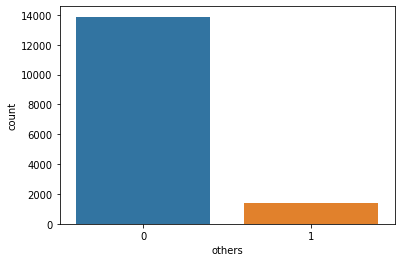

In [32]:
#countplot for accidents involving goods vehicles
sns.countplot(data= df, x ='others');

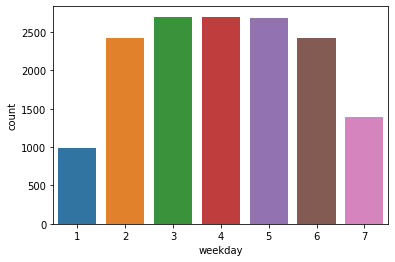

In [33]:
#countplot for weekday of accident
sns.countplot(data= df, x ='weekday');

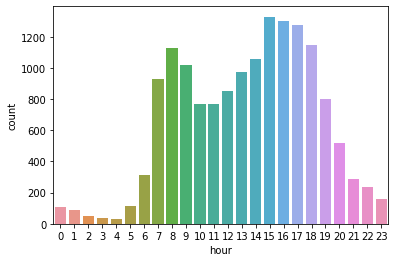

In [34]:
#countplot for hour of accident
sns.countplot(data= df, x ='hour');

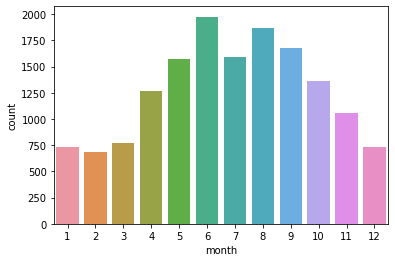

In [35]:
#countplot for accident month
sns.countplot(data= df, x ='month');

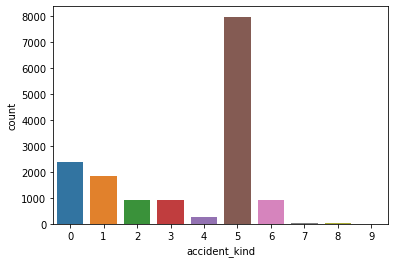

In [36]:
#countplot for kind of accident
sns.countplot(data= df, x ='accident_kind');

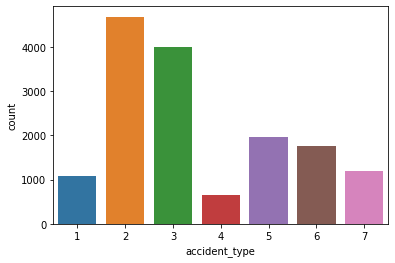

In [37]:
#countplot for type of accident
sns.countplot(data= df, x ='accident_type');

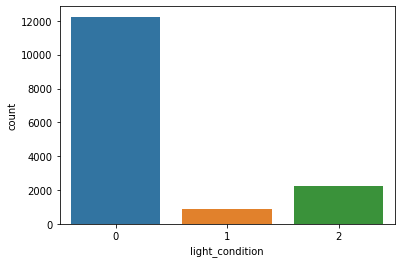

In [38]:
#countplot for accidents depending on light conditions
sns.countplot(data= df, x ='light_condition');

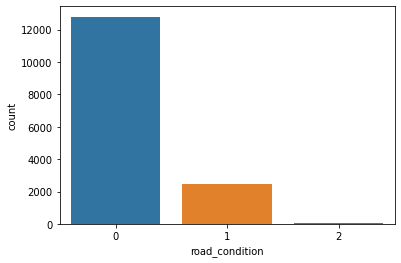

In [39]:
#countplot for accidents depending on road condition
sns.countplot(data= df, x ='road_condition');

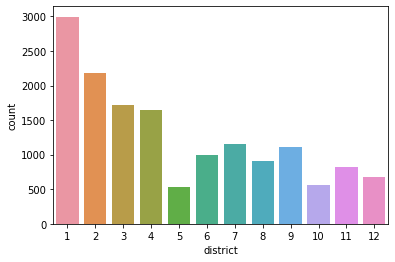

In [59]:
#countplot for accidents per district
sns.countplot(data= df, x ='district');

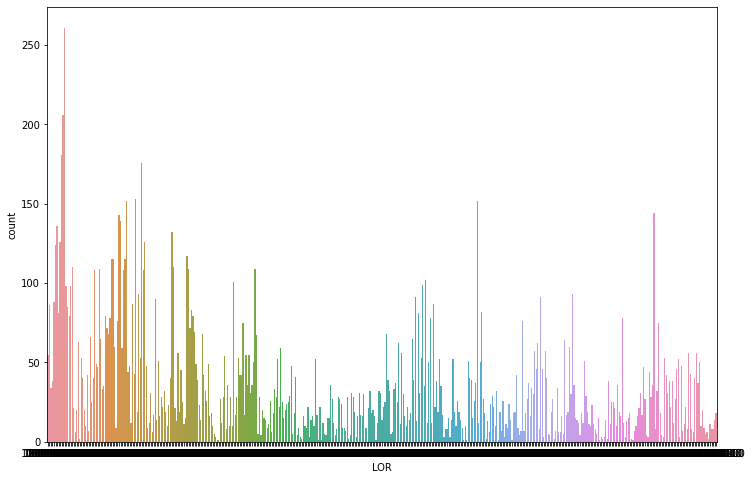

In [74]:
#countplot for accidents per LOR
plt.figure(figsize=(12,8))
sns.countplot(data= df, x = df[df'LOR' );

In [76]:
df['XGCSWGS84'].nunique()

14602

In [40]:
#checking for duplicates in index
df.index.is_unique

False

In [43]:
df.index.duplicated()

array([False, False, False, ..., False, False, False])

In [44]:
#resetting index to avoid inidex duplicates
df = df.reset_index(drop=True)

In [45]:
#confirming it worked
df.index.is_unique

True

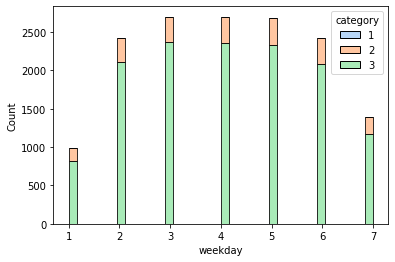

In [58]:
#histplot for accident category/weekday
sns.histplot(x='weekday', hue='category', data=df, stat= 'count', multiple= 'stack', palette='pastel');

In [66]:
df.corr()

,district,LOR,LOR_2021,year,month,hour,weekday,category,accident_kind,accident_type,...,car,pedestrian,motorcycle,goods_vehicle,others,road_condition,LINREFX,LINREFY,XGCSWGS84,YGCSWGS84
district,1.000000,0.997623,0.996532,0.034138,0.003766,-0.025135,0.002937,-0.054854,0.036678,-0.043917,...,0.049694,-0.042468,-0.035320,0.005218,-0.018653,-0.013076,0.276512,-0.165740,0.268818,-0.186165
LOR,0.997623,1.000000,0.999020,0.033230,0.003891,-0.025513,0.003218,-0.055374,0.037043,-0.044574,...,0.050794,-0.041916,-0.037529,0.005117,-0.019677,-0.012054,0.273273,-0.160675,0.265821,-0.180885
LOR_2021,0.996532,0.999020,1.000000,0.040677,-0.007759,-0.020272,0.006086,-0.054684,0.036163,-0.033635,...,0.055132,-0.035269,-0.033339,0.009619,-0.019576,-0.012234,0.277025,-0.154692,0.269787,-0.175268
year,0.034138,0.033230,0.040677,1.000000,0.012463,0.025733,-0.001170,0.010832,-0.030467,-0.009587,...,-0.008088,-0.020079,0.005018,-0.010406,-0.036515,0.051709,0.010306,-0.018219,0.009433,-0.018889
month,0.003766,0.003891,-0.007759,0.012463,1.000000,-0.024436,0.005066,0.010947,-0.024246,-0.004513,...,-0.013839,-0.003937,0.019278,-0.009950,-0.000120,0.021056,-0.007417,0.005489,-0.007162,0.006018
hour,-0.025135,-0.025513,-0.020272,0.025733,-0.024436,1.000000,0.003638,-0.002614,-0.018719,0.042093,...,0.017773,0.039635,0.018386,-0.075014,-0.015918,-0.023059,-0.013051,-0.009194,-0.013508,-0.008093
weekday,0.002937,0.003218,0.006086,-0.001170,0.005066,0.003638,1.000000,-0.007070,0.003427,-0.000661,...,0.013773,-0.001653,-0.001535,-0.008558,-0.006034,0.002510,-0.001361,0.015314,-0.000615,0.015309
category,-0.054854,-0.055374,-0.054684,0.010832,0.010947,-0.002614,-0.007070,1.000000,0.006237,0.048337,...,0.107121,-0.005141,-0.002093,-0.088768,0.023408,0.008394,-0.002004,0.019666,-0.001065,0.019768
accident_kind,0.036678,0.037043,0.036163,-0.030467,-0.024246,-0.018719,0.003427,0.006237,1.000000,-0.217822,...,0.139833,0.243751,0.001224,0.003261,-0.071792,-0.041969,0.018241,0.025163,0.019485,0.023544
accident_type,-0.043917,-0.044574,-0.033635,-0.009587,-0.004513,0.042093,-0.000661,0.048337,-0.217822,1.000000,...,-0.078966,0.203063,-0.026507,-0.008721,0.065540,-0.047716,-0.026210,-0.017806,-0.027114,-0.015604


<AxesSubplot:>

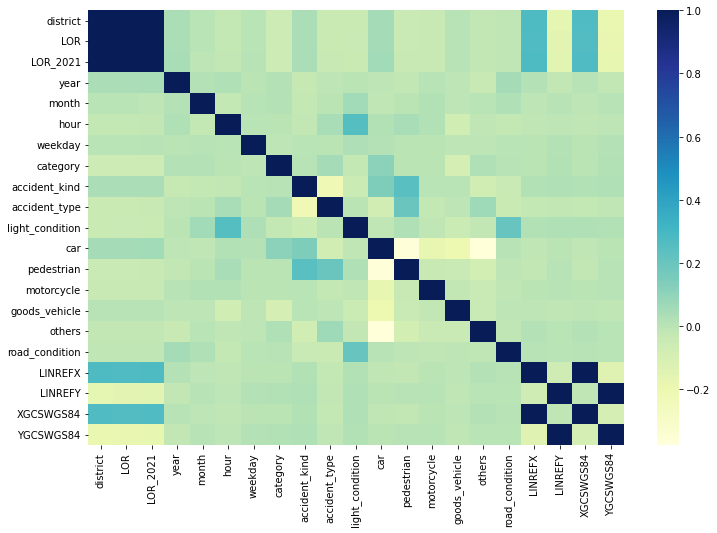

In [68]:
#correlation table
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap="YlGnBu")

In [70]:
df['LOR'].nunique()

443

## infraVelo API

In [ ]:
url = 'https://www.infravelo.de/api/v1/projects/'
url2 = 'https://www.infravelo.de/api/v1/projects/50/50/'
url3 = 'https://www.infravelo.de/api/v1/projects/100/50/'
url4 = 'https://www.infravelo.de/api/v1/projects/150/50/'
response = requests.get(url3).json()
response

In [ ]:
names=[]
for i in range(len(response['results'])):
    names.append(response['results'][i]['title'])
pd.DataFrame(names)

In [ ]:
#Reading APIs

#for i in range(1,50):
#    print(i, response['results'][i]['title'])

In [ ]:
#KML data stlip / Wisbyer Strasse
kml_str = response['results'][41]['kml'].split()
kml_str

In [ ]:
kml_str[44]

In [ ]:
#Organize KML data per block (only the first one)
coordinate1, coordinate2, coordinate3, coordinate4, coordinate5 = [],[],[],[],[]
for i in range(len(kml_str)):
    if kml_str[i] == '<coordinates>':
        coordinate1.append(kml_str[i+1])
#    if kml_str[i] != '</coordinates>':

print(coordinate1)

In [ ]:
#Manually took the coordinates for test
test_location = [13.4405757994,52.4737692995,
 13.4405113004,52.4738815993,
 13.4404971005,52.4739062994,
 13.4404219001,52.474037199,
 13.4403887007,52.4740936991,
 13.4403685999,52.4741284993,
 13.4403181006,52.4742146991,
 13.4402538,52.4743250988,
 13.4400138998,52.4747357993,
 13.4399429006,52.4748919993,
 13.4398426995,52.4751500993,
 13.4398239993,52.4751980988,
 13.4397882993,52.475289899]
test_tup = tuple(test_location)
test_location = np.array(test_location).reshape(13,2)
test_location[:,0], test_location[:,1] = test_location[:,1], test_location[:,0].copy()

In [ ]:
points = tuple(test_location)
points

In [ ]:
test_location2 = [13.4495974004,52.537157899,
 13.4496928005,52.5370618994,
 13.4497330002,52.537021499,
 13.4500717999,52.536680499,
 13.4501126004,52.5366449993,
 13.4502748004,52.5364561987,
 13.4506326007,52.5361042989,
 13.4509465006,52.5358140995,
 13.4510125007,52.535746399,
 13.4514056996,52.5353429994,
 13.4515473999,52.5351961991,
 13.4517637993,52.5349717992,
 13.4517834005,52.5349520992,
 13.4518773006,52.5348575987,
 13.4520993995,52.5346339991,
 13.4524955995,52.5342245987,
 13.4529111006,52.5337948994,
 13.4532731002,52.5334266992,
 13.4533520007,52.533346299,
 13.4533856006,52.5333112992,
 13.4536300996,52.5330603989,
 13.4537551993,52.5329256994,
 13.4538386007,52.5328358991,
 13.4542387,52.532435899,
13.4552262993,52.5314222992,
13.4556814993,52.5309736987,
13.4557106998,52.5309448995,
13.4558564007,52.5308011988,
13.4559387993,52.5307130994,
13.4559658004,52.5306841995,
13.4562414006,52.530389499,
13.4564922995,52.5301492992,
13.4566411002,52.5300068994,
13.4567235004,52.5299279991,
13.4567877996,52.5298664994,
13.4571880004,52.5294601988,
13.4574770006,52.5291722992,
13.4575215004,52.5291279989,
13.4576247996,52.5290250992]
test_tup2 = tuple(test_location2)
test_location2 = np.array(test_location2).reshape(39,2)
test_location2[:,0], test_location2[:,1] = test_location2[:,1], test_location2[:,0].copy()
points2 = tuple(test_location2)

In [ ]:
test_location3 = [13.4301194998,52.5513524989,
 13.4299060004,52.5514397991,
 13.4288630002,52.5518523995,
 13.4280413005,52.5521647987,
 13.4274770995,52.5523852991,
 13.4274448004,52.5523978988,
 13.4273235004,52.5524273988,
 13.4271935996,52.552457099,
 13.4269072006,52.5525224995,
 13.4265339005,52.5525745992,
 13.4256882003,52.552666899,
 13.4255319997,52.5526838994,
 13.4253715994,52.5527013993,
 13.4253189993,52.5527070994,
 13.4245639994,52.5527907994,
 13.4240729997,52.5528430995,
 13.4238913993,52.5528651991,
 13.4233038,52.5529282991,
 13.4224540995,52.5530204992,
 13.4220908999,52.5530595989,
 13.4208025006,52.5532058993,
 13.4199398998,52.5533038991,
 13.4196113997,52.5533412993,
 13.4184403998,52.5534555987,
 13.4159971003,52.5537321993,
 13.4157511004,52.5537588993,
 13.4154117007,52.5537956987,
 13.4149393995,52.5538518994,
 13.4148765001,52.5538578993,
 13.4147283003,52.5538674995]
test_tup3 = tuple(test_location3)
test_location3 = np.array(test_location3).reshape(30,2)
test_location3[:,0], test_location3[:,1] = test_location3[:,1], test_location3[:,0].copy()
points3 = tuple(test_location2)

## Map

In [77]:
#Cutting df only for the test area. 
df1 = df[df.XGCSWGS84 >= 13.43]
df2 = df1[df1.XGCSWGS84 <= 13.45]
df3 = df2[df2.YGCSWGS84 >= 52.47]
df4 = df3[df3.YGCSWGS84 <= 52.48]
test_accidents = tuple(np.array([df4.YGCSWGS84, df4.XGCSWGS84]).T.tolist())

In [79]:
#General accidents data per year
accidents_2018 = tuple(np.array([df[df.year == 2018].YGCSWGS84, df[df.year == 2018].XGCSWGS84]).T.tolist())
accidents_2019 = tuple(np.array([df[df.year == 2019].YGCSWGS84, df[df.year == 2019].XGCSWGS84]).T.tolist())
accidents_2020 = tuple(np.array([df[df.year == 2020].YGCSWGS84, df[df.year == 2020].XGCSWGS84]).T.tolist())

In [ ]:
#Plotting

#accidents = test_accidents

m = folium.Map(location=[52.52000, 13.4050],tiles='Stamen Toner', zoom_start=15)
#folium.PolyLine(locations=, color='green', weight=10, opacity=1).add_to(m)
#markers=[(52.475,13.438),(52.476, 13.441),(52.473,13.439),(52.473,13.442)]
for each in accidents_2018: # 11 accidents
    folium.CircleMarker(each, radius=2, color='blue').add_to(m)
#for each in accidents_2019: # 9 accidents
    #folium.CircleMarker(each, radius=2, color='yellow').add_to(m)
#for each in accidents_2020: # 6 accidents
   # folium.CircleMarker(each, radius=2,color='red').add_to(m)
#    folium.Marker(each).add_to(m) # Very Heavy!!
m

In [ ]:
#coordinates = [48.8649224, 2.3800903] # 16 Villa Gaudelet, Paris

#m = folium.Map(location=coordinates, zoom_start=8)
#folium.Marker(coordinates, tooltip='Le Wagon Paris').add_to(m)
#folium.Circle(coordinates, radius=100 * 1000).add_to(m)
#m

In [ ]:
#def geocode(address):
#    params = { "q": address, 'format': 'json' }
#    places = requests.get(f"https://nominatim.openstreetmap.org/search", params=params).json()
#    return [places[0]['lat'], places[0]['lon']]
#    
#def draw_100km_map(address):
#    coordinates = geocode(address)
#    m = folium.Map(location=coordinates, zoom_start=8)
#    folium.Marker(coordinates, tooltip='Le Wagon Paris').add_to(m)
#    folium.Circle(coordinates, radius=100 * 1000).add_to(m)
#    return m

In [ ]:
#address = input()
#draw_100km_map(address)

In [ ]:
#EXAMPLE OF A HEATMAP
#from folium.plugins import HeatMap

### Create a Map instance
#mp = folium.Map(location=[52.5, 13.5], tiles = 'stamentoner', zoom_start=9, control_scale=True)

### Add heatmap to map instance
#### Available parameters: HeatMap(data, name=None, min_opacity=0.5, max_zoom=18, max_val=1.0, radius=25, blur=15, gradient=None, overlay=True, control=True, show=True)
#HeatMap(points3).add_to(mp)

### Alternative syntax:
###m.add_child(HeatMap(points_array, radius=15))

#### Show map
#mp

## Calculate Distance from coordinates

In [ ]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

## EDA

In [ ]:
df.keys()

In [ ]:
#dropping unnecessary columns
df = df.drop(columns=['IstRad', 'LAND'])

In [ ]:
df

In [ ]:
df.info()

In [ ]:
#Missing values
df.isnull().sum()

In [ ]:
#NaN percentage for each column
df.isnull().sum().sort_values(ascending=False)/len(df) 

In [ ]:
#counting duplicates
df.duplicated().sum()

In [ ]:
#df['USTRZUSTAND'] = cars['USTRZUSTAND'].map({"USTRZUSTAND":4,
                                                    "six":6,
                                                    "five":5,
                                                    "eight":8,
                                                    "two":2,
                                                    "three":3,
                                                    "twelve":12})